In [1]:
##############################################
# 1. LIBRARIES (Kütüphanelerin İçe Aktarılması)
##############################################
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU

# Reproducibility (Tekrarlanabilirlik) için tohum ayarlaması:
np.random.seed(1234)
PYTHONHASHSEED = 0



In [2]:
##############################################
# 2. DATA LOADING (VERİ SETLERİNİN YÜKLENMESİ)
##############################################

# 2.1. TRAIN DATA (Eğitim Verisi)
train_path = '/kaggle/input/pred-maintanance-data/PM_train.txt'
train_df = pd.read_csv(train_path, sep=" ", header=None)
print("Train veri satır sayısı:", len(train_df))

# 2.2. TEST DATA (Test Verisi)
test_path = '/kaggle/input/pred-maintanance-data/PM_test.txt'
test_df = pd.read_csv(test_path, sep=" ", header=None)
print("Test veri satır sayısı:", len(test_df))

# 2.3. GROUND TRUTH (Test Ground Truth Verisi)
truth_path = '/kaggle/input/pred-maintanance-data/PM_truth.txt'
truth_df = pd.read_csv(truth_path, sep=" ", header=None)

# İlk 100 satır eğitim verisini gözlemleyelim (opsiyonel)
print(train_df.head(5))

# NAN içeren kolonları atıyoruz (sadece NAN içeren kolonlar 26 ve 27’dir)
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)
truth_df.dropna(axis=1, inplace=True)

##############################################
# 3. COLUMN NAMES (SÜTUN İSİMLERİNİN AYARLANMASI)
##############################################
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 
              's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 
              's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 
              's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

print("Train data örnekleri:")
print(train_df.head(2))
print("Test data örnekleri:")
print(test_df.head(2))

Train veri satır sayısı: 20631
Test veri satır sayısı: 13096
   0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190 NaN NaN  
1  ...  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236 NaN NaN  
2  ...  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442 NaN NaN  
3  ...  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739 NaN NaN  
4  ...  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044 NaN NaN  

[5 rows x 28 columns]
Train dat

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [3]:
##############################################
# 4. DATA PREPROCESSING FOR TRAIN SET (EĞİTİM VERİSİNİN ÖN İŞLENMESİ)
##############################################

# 4.1. Sıralama: Her motor (id) için cycle'lara göre sırala
train_df.sort_values(['id', 'cycle'], inplace=True)

# 4.2. RUL Hesaplama:
# Her motor için maksimum cycle değerini bul ve RUL = max - cycle
rul_train = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul_train.columns = ['id', 'max']
train_df = train_df.merge(rul_train, on='id', how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# 4.3. Target Variable (Etiket) Oluşturma:
# w1: Arıza öncesi pencere. Burada w1 = 30
w1 = 30
train_df['failure_within_w1'] = np.where(train_df['RUL'] <= w1, 1, 0)

# 4.4. Normalizasyon:
# İlk olarak cycle_norm adlı sütunu oluşturuyoruz.
train_df['cycle_norm'] = train_df['cycle']
# Normalizasyon için sensor verileri (id, cycle, RUL, failure_within_w1 hariç) kullanılacak.
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'failure_within_w1'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
# Normalleştirilmiş verilerle orijinal (non-normalized) sütunları birleştiriyoruz.
join_df = train_df[['id', 'cycle', 'RUL', 'failure_within_w1']].join(norm_train_df)
train_df = join_df.reindex(columns=train_df.columns)

print("\n=== Train Set Data Processing ===")
print(train_df.head(5))


=== Train Set Data Processing ===
   id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.459770  0.166667       0.0  0.0  0.183735  0.406802  0.309757   
1   1      2  0.609195  0.250000       0.0  0.0  0.283133  0.453019  0.352633   
2   1      3  0.252874  0.750000       0.0  0.0  0.343373  0.369523  0.370527   
3   1      4  0.540230  0.500000       0.0  0.0  0.343373  0.256159  0.331195   
4   1      5  0.390805  0.333333       0.0  0.0  0.349398  0.257467  0.404625   

    s5  ...       s15  s16       s17  s18  s19       s20       s21  RUL  \
0  0.0  ...  0.363986  0.0  0.333333  0.0  0.0  0.713178  0.724662  191   
1  0.0  ...  0.411312  0.0  0.333333  0.0  0.0  0.666667  0.731014  190   
2  0.0  ...  0.357445  0.0  0.166667  0.0  0.0  0.627907  0.621375  189   
3  0.0  ...  0.166603  0.0  0.333333  0.0  0.0  0.573643  0.662386  188   
4  0.0  ...  0.402078  0.0  0.416667  0.0  0.0  0.589147  0.704502  187   

   failure_within_w1  cycle

In [4]:
##############################################
# 5. DATA PREPROCESSING FOR TEST SET (TEST VERİSİNİN ÖN İŞLENMESİ)
##############################################

# 5.1. Test verisini cycle_norm ile genişletelim.
test_df['cycle_norm'] = test_df['cycle']
# 5.2. Test verisinde normalizasyon: Train sette kullandığımız scaler'ı kullanıyoruz.
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
test_df = test_df.reset_index(drop=True)

# 5.3. Ground Truth ile Test RUL Hesaplama:
# Her motor için test setinde maksimum cycle değerini bul.
rul_test = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul_test.columns = ['id', 'max']
# Ground truth: additional RUL bilgisi
truth_df.columns = ['additional_rul']
truth_df['id'] = truth_df.index + 1  # id'ler 1'den başlıyor
truth_df['max'] = rul_test['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)
# Test verisine RUL bilgisini ekleyelim.
test_df = test_df.merge(truth_df, on='id', how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
# Test etiketini oluşturma: failure_within_w1
test_df['failure_within_w1'] = np.where(test_df['RUL'] <= w1, 1, 0)

print("\n=== Test Set Data Processing ===")
print(test_df.head(5))



=== Test Set Data Processing ===
   id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154  0.408001   
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082  0.332039   

    s5  ...       s15  s16       s17  s18  s19       s20       s21  \
0  0.0  ...  0.308965  0.0  0.333333  0.0  0.0  0.558140  0.661834   
1  0.0  ...  0.213159  0.0  0.416667  0.0  0.0  0.682171  0.686827   
2  0.0  ...  0.458638  0.0  0.416667  0.0  0.0  0.728682  0.721348   
3  0.0  ...  0.257022  0.0  0.250000  0.0  0.0  0.666667  0.662110   
4  0.0  ...  0.300885  0.0  0.166667  0.0  0.0  0.658915  0.716377   

   cycle_norm  RUL  failure_within_w1  
0     0.00000  142

In [5]:
##############################################
# 6. GOSSIP DATA PROCESSING (Gossip İçin Veri İşleme)
##############################################
# Eğitim verisini, gossip öğrenimi için motor id'lerine göre node'lara böleceğiz.

num_nodes = 10
sorted_ids = sorted(train_df['id'].unique())
motors_per_node = len(sorted_ids) // num_nodes

In [6]:


# Her node için, ilgili motor id'lerinden oluşan veriyi ayrı ayrı birleştiriyoruz.
node_train_data = {}
for node in range(num_nodes):
    motor_ids = sorted_ids[node*motors_per_node : (node+1)*motors_per_node]
    node_data = pd.concat([train_df[train_df['id'] == mid] for mid in motor_ids])
    node_data.sort_values(['id', 'cycle'], inplace=True)
    node_train_data[node+1] = node_data
    print(f"Node {node+1}: {len(node_data)} satır, motor id'leri: {motor_ids}")

# Şimdilik gossip'in eğitim kısmında kullanılacak veri, node_train_data sözlüğünde.
# Bu aşamadan sonra, her node için zaman serisi (sequence) üretimi, model tanımlaması ve gossip exchange
# gibi adımları uygulayarak eğitim sürecine geçebiliriz.

##############################################
# İLERİ ADIM:
# – Her node için belirli pencere uzunluğu (ör. 50) kadar ardışık veriden sequence (zaman serisi) üretilir.
# – LSTM veya başka bir RNN modeli tanımlanarak her node için eğitim yapılır.
# – Her epoch sonunda, node'lar arası gossip exchange (ağırlık paylaşımı) gerçekleştirilir.
# – Son aşamada test verileri üzerinden model performansı değerlendirilir.
##############################################

print("\nVeri işleme adımları tamamlandı. Şimdi model oluşturma ve gossip eğitim kısmına geçebiliriz.")

Node 1: 2136 satır, motor id'leri: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Node 2: 2032 satır, motor id'leri: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Node 3: 1819 satır, motor id'leri: [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Node 4: 1839 satır, motor id'leri: [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Node 5: 2083 satır, motor id'leri: [41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Node 6: 2033 satır, motor id'leri: [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Node 7: 2188 satır, motor id'leri: [61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
Node 8: 2008 satır, motor id'leri: [71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
Node 9: 2242 satır, motor id'leri: [81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
Node 10: 2251 satır, motor id'leri: [91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

Veri işleme adımları tamamlandı. Şimdi model oluşturma ve gossip eğitim kısmına geçebiliriz.


In [7]:
##############################################
# 7. GENERATING INPUT SEQUENCE (Zaman Serisi Oluşturma)
##############################################
# Kullanılacak pencere uzunluğu
sequence_length = 50

# Aşağıdaki fonksiyon, belirli bir motor (engine) için ardışık sequence'ler oluşturur.
def sequence_generator(feature_df, seq_length, seq_cols):
    """
    Verilen DataFrame'den, belirtilen sütun(lar)ı kullanarak, ardışık seq_length uzunluğunda
    diziler (sequence) üretir. Sequence, her seferinde 'seq_length' ardışık zaman adımını içerir.
    """
    # DataFrame'i NumPy 2D array'e çeviriyoruz.
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]
    
    # Sequence üretimi: 0'dan (num_elements - seq_length)'e kadar,
    # her seferinde ardışık seq_length zaman adımını al.
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

# Test: Her motor için "s2" özelliğini kullanarak sequence üretelim.
# (Örneğin: yalnızca "s2" sütununu alıyoruz. Bu, shape (num_samples, seq_length, 1) verecektir.)
seq_gen = (
    list(sequence_generator(train_df[train_df['id'] == engine_id], sequence_length, ["s2"]))
    for engine_id in train_df['id'].unique()
)

# Tüm motorlara ait üretilen sequence'leri birleştirip NumPy array'e çeviriyoruz.
seq_set = np.concatenate(list(seq_gen)).astype(np.float32)
print("\nSeq_set shape (Train):", seq_set.shape)  # Örnek çıktı: (15631, 50, 1)

# Label üretimi için fonksiyon:
def label_generator(label_df, seq_length, label_cols):
    """
    Verilen DataFrame'deki etiket sütunlarından (örneğin, 'failure_within_w1') 
    NumPy 2D array üretir. İlk seq_length adet etiket atlanır.
    """
    label_array = label_df[label_cols].values
    num_elements = label_array.shape[0]
    # İlk seq_length etiket, ilk sequence'e karşılık gelmeyeceği için atlanır.
    return label_array[seq_length:num_elements, :]

# Her motor için label üretelim.
label_gen = [
    label_generator(train_df[train_df['id'] == engine_id], sequence_length, ['failure_within_w1'])
    for engine_id in train_df['id'].unique()
]
label_set = np.concatenate(label_gen).astype(np.float32)
print("Label_set shape (Train):", label_set.shape)  # Örnek çıktı: (15631, 1)


Seq_set shape (Train): (15631, 50, 1)
Label_set shape (Train): (15631, 1)


Node 1: 1636 sequences generated.
Node 2: 1532 sequences generated.
Node 3: 1319 sequences generated.
Node 4: 1339 sequences generated.
Node 5: 1583 sequences generated.
Node 6: 1533 sequences generated.
Node 7: 1688 sequences generated.
Node 8: 1508 sequences generated.
Node 9: 1742 sequences generated.
Node 10: 1751 sequences generated.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Node 1 LSTM model created.
Node 2 LSTM model created.
Node 3 LSTM model created.
Node 4 LSTM model created.
Node 5 LSTM model created.
Node 6 LSTM model created.
Node 7 LSTM model created.
Node 8 LSTM model created.
Node 9 LSTM model created.
Node 10 LSTM model created.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 100)             │          50,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,651 (315.04 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/50 - Training on all nodes and performing gossip exchange
Node 1: Training on 1636 samples
8/8 - 4s - 557ms/step - accuracy: 0.7973 - loss: 0.5340 - val_accuracy: 0.6220 - val_loss: 0.8171
Node 2: Training on 1532 samples
8/8 - 2s - 282ms/step - accuracy: 0.8041 - loss: 0.5194 - val_accuracy: 0.5974 - val_loss: 0.7643
Node 3: Training on 1319 samples
7/7 - 2s - 287ms/step - accuracy: 0.7749 - loss: 0.5543 - val_accuracy: 0.5303 - val_loss: 0.8119
Node 4: Training on 1339 samples
7/7 - 2s - 290ms/step - accuracy: 0.7036 - loss: 0.5670 - val_accuracy: 0.5373 - val_loss: 0.9280
Node 5: Training on 1583 samples
8/8 - 2s - 254ms/step - accuracy: 0.8110 - loss: 0.5211 - val_accuracy: 0.6125 - val_loss: 0.7134
Node 6: Training on 1533 samples
8/8 - 2s - 250ms/step - accuracy: 0.7335 - loss: 0.5426 - val_accuracy: 0.5974 - val_loss: 0.8414
Node 7: Training on 1688 samples
9/9 - 2s - 232ms/step - accuracy: 0.7511 - loss: 0.5354 - val_accuracy: 0.6353 - val_loss: 0.8981
Node 8: Tra

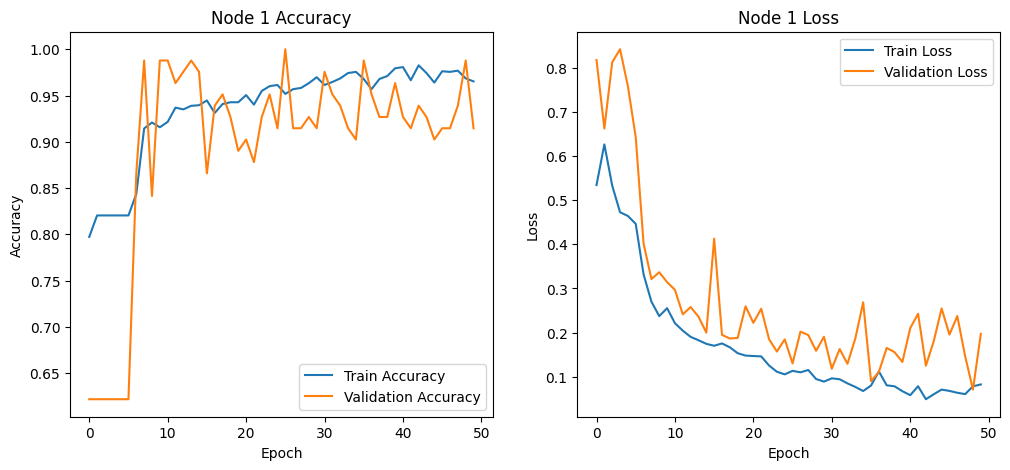

In [8]:
##############################################
# LSTM Model with Gossip Integration for 25 Features with History Saving
##############################################

# 1. LSTM Model Tanımlama Fonksiyonu (Verilen Mimaride)
def build_lstm_model(input_shape, out_dim):
    model = Sequential()
    model.add(LSTM(units=100, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=out_dim, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 2. Node Bazlı Sequence ve Label Üretimi (25 Feature için)
# Önce, 25 özelliği içeren sequence sütunlarını tanımlayalım:
sensor_cols = ['s' + str(i) for i in range(1, 22)]
sequence_cols_25 = ['setting1', 'setting2', 'setting3', 'cycle_norm'] + sensor_cols

# Belirlenen pencere uzunluğu:
sequence_length = 50

# Her node için, ilgili motor verilerinden sequence (zaman serisi) ve label setleri üreten fonksiyon:
def generate_sequences_for_node(node_data, seq_length, seq_cols):
    sequences = []
    labels = []
    # Her motor (engine) için ayrı ayrı:
    for engine_id in node_data['id'].unique():
        engine_data = node_data[node_data['id'] == engine_id].sort_values('cycle')
        # Sequence'leri ve etiketleri elde etmek için DataFrame'i NumPy array'e çeviriyoruz.
        arr = engine_data[seq_cols].values
        lab_arr = engine_data['failure_within_w1'].values
        if len(arr) > seq_length:
            for i in range(len(arr) - seq_length):
                sequences.append(arr[i:i+seq_length])
                labels.append(lab_arr[i+seq_length])
    return np.array(sequences).astype(np.float32), np.array(labels).reshape(-1, 1).astype(np.float32)

# node_train_data: Daha önce oluşturduğunuz, eğitim verisini motor id'lerine göre bölen sözlük.
# Örneğin: {1: df_node1, 2: df_node2, ...}
# Şimdi, her node için 25 feature'lı sequence ve label setlerini üretiyoruz:
node_sequences_25 = {}
node_labels = {}
for node_id, node_data in node_train_data.items():
    X_node, y_node = generate_sequences_for_node(node_data, sequence_length, sequence_cols_25)
    node_sequences_25[node_id] = X_node
    node_labels[node_id] = y_node
    print(f"Node {node_id}: {X_node.shape[0]} sequences generated.")

# 3. Her Node için LSTM Modeli Oluşturma
# input_shape: (sequence_length, number of features)
features_dim = len(sequence_cols_25)  # Örneğin 25
out_dim = 1  # failure_within_w1: Binary
input_shape = (sequence_length, features_dim)

gossip_models = {}
for node_id in node_train_data.keys():
    gossip_models[node_id] = build_lstm_model(input_shape, out_dim)
    print(f"Node {node_id} LSTM model created.")

# (Örneğin, aşağıdaki kod Node 1'in özetini gösterecektir.)
print(gossip_models[1].summary())

# 4. Gossip Exchange Fonksiyonu
def gossip_ring_exchange(models_dict):
    keys = sorted(models_dict.keys())
    new_weights = {}
    n = len(keys)
    for i, key in enumerate(keys):
        left_key = keys[i - 1]  # İlk eleman için listenin son elemanı
        right_key = keys[(i + 1) % n]
        current_w = models_dict[key].get_weights()
        left_w = models_dict[left_key].get_weights()
        right_w = models_dict[right_key].get_weights()
        # Her katman için ağırlıkları ortalıyoruz:
        avg_w = [(cw + lw + rw) / 3.0 for cw, lw, rw in zip(current_w, left_w, right_w)]
        new_weights[key] = avg_w
    for key in keys:
        models_dict[key].set_weights(new_weights[key])
    return models_dict

# 5. GOSSIP TRAINING WITH LSTM (25 FEATURES) - FINAL INTEGRATED TRAINING CODE WITH HISTORY SAVING
import time

# Eğitim parametreleri:
epochs = 50
batch_size = 200

# Her node için eğitim metriklerini saklamak için bir dictionary oluşturuyoruz:
node_histories = {
    node_id: {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    for node_id in gossip_models.keys()
}

start = time.time()

# Her epoch'da her node için eğitim yapıp ardından gossip exchange gerçekleştiriyoruz.
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} - Training on all nodes and performing gossip exchange")
    
    # Her node için ayrı ayrı eğitim:
    for node_id in sorted(gossip_models.keys()):
        X_node = node_sequences_25[node_id]  # Node'ya ait input sequence seti (örneğin, shape: [num_samples, 50, 25])
        y_node = node_labels[node_id]          # Node'ya ait label seti (örneğin, shape: [num_samples, 1])
        print(f"Node {node_id}: Training on {X_node.shape[0]} samples")
        
        # Validation split ekleyerek eğitim yapıyoruz:
        history = gossip_models[node_id].fit(
            X_node, y_node,
            epochs=1,
            batch_size=batch_size,
            validation_split=0.05,
            verbose=2,
            callbacks=[
                keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='min'),
                keras.callbacks.ModelCheckpoint(
                    f'/kaggle/working/binary_model_node_{node_id}.keras',
                    monitor='loss', save_best_only=True, mode='min', verbose=0
                )
            ]
        )
        # Eğitim history'sini kaydediyoruz:
        for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
            node_histories[node_id][key].extend(history.history[key])
    
    # Epoch sonunda gossip exchange gerçekleştir:
    gossip_models = gossip_ring_exchange(gossip_models)
    print("Gossip exchange completed for this epoch.")

end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

# Örnek: Node 1'in eğitim geçmişi üzerinden doğruluk (accuracy) ve loss eğrilerini çizelim.
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(node_histories[1]['accuracy'], label='Train Accuracy')
ax1.plot(node_histories[1]['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Node 1 Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(node_histories[1]['loss'], label='Train Loss')
ax2.plot(node_histories[1]['val_loss'], label='Validation Loss')
ax2.set_title('Node 1 Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()


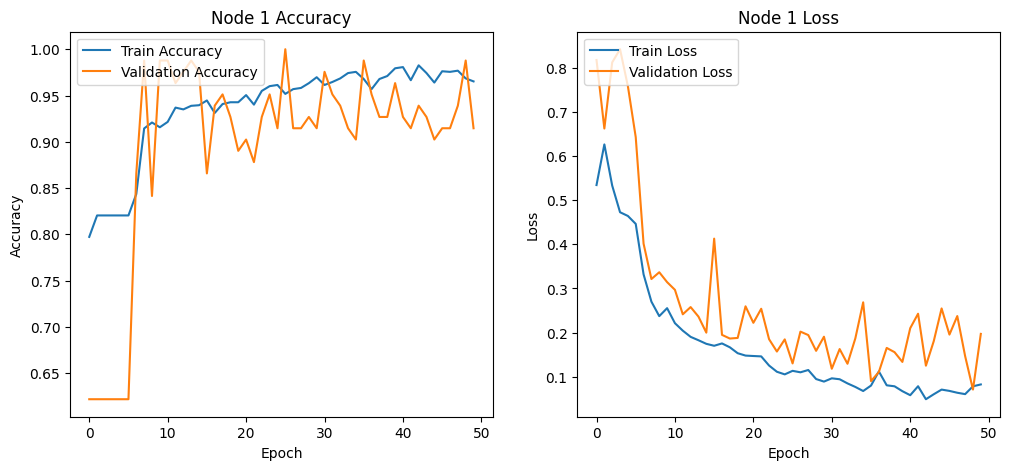

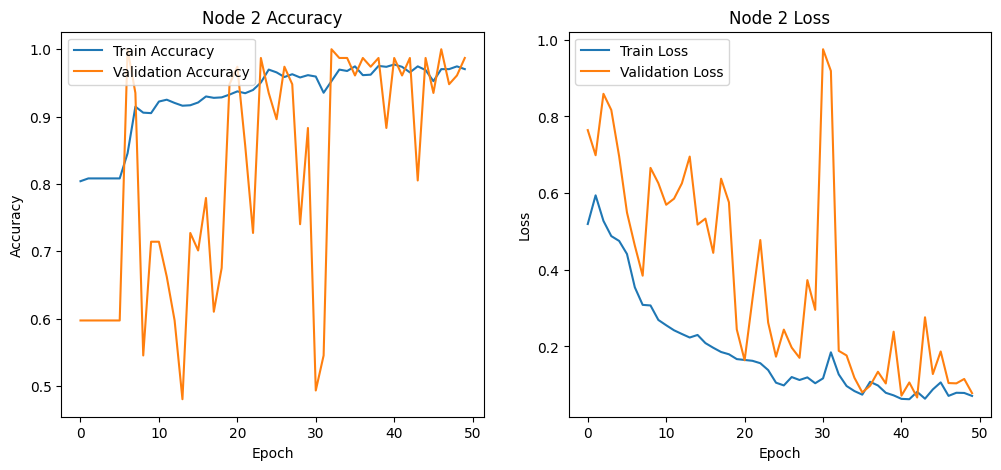

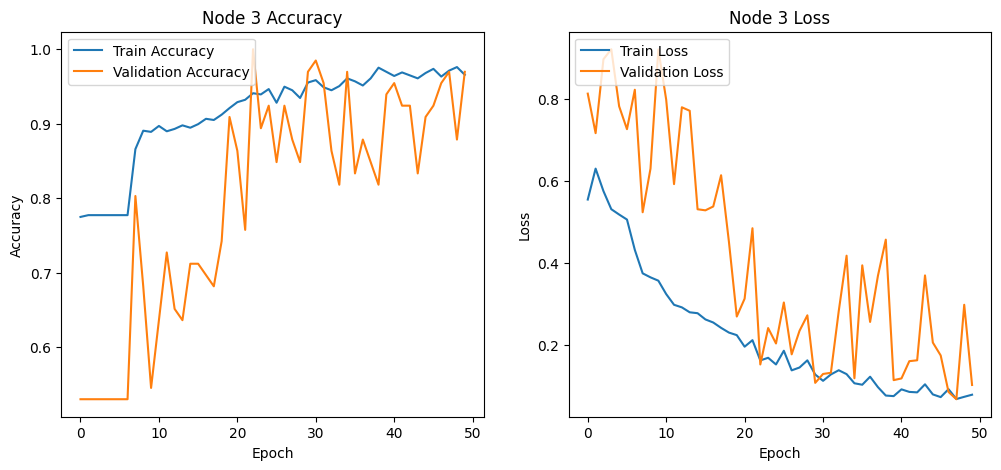

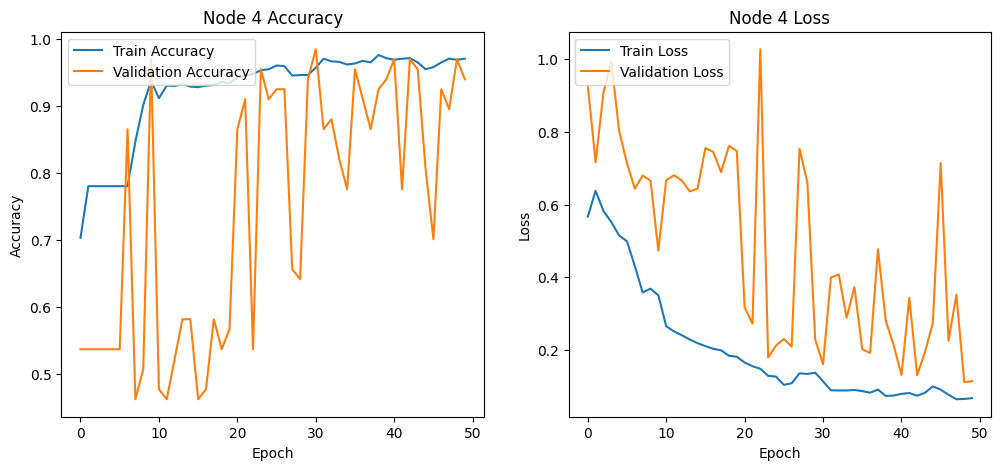

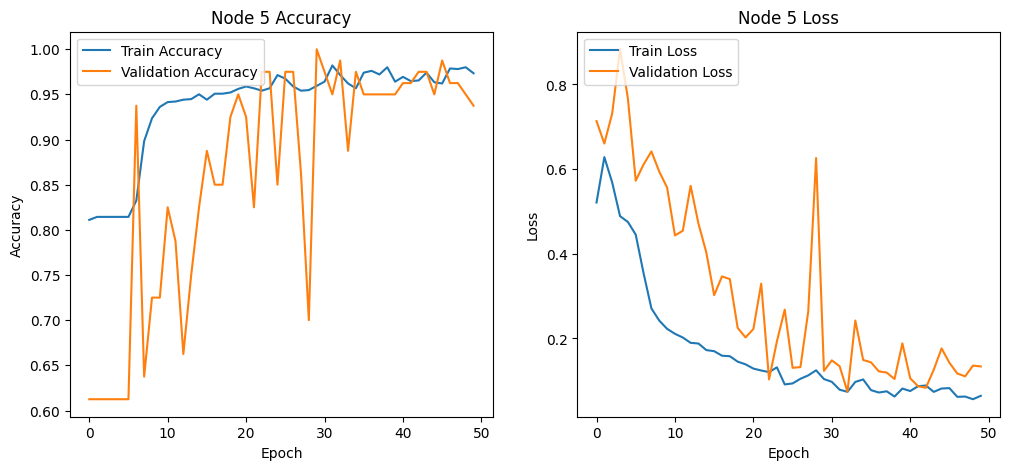

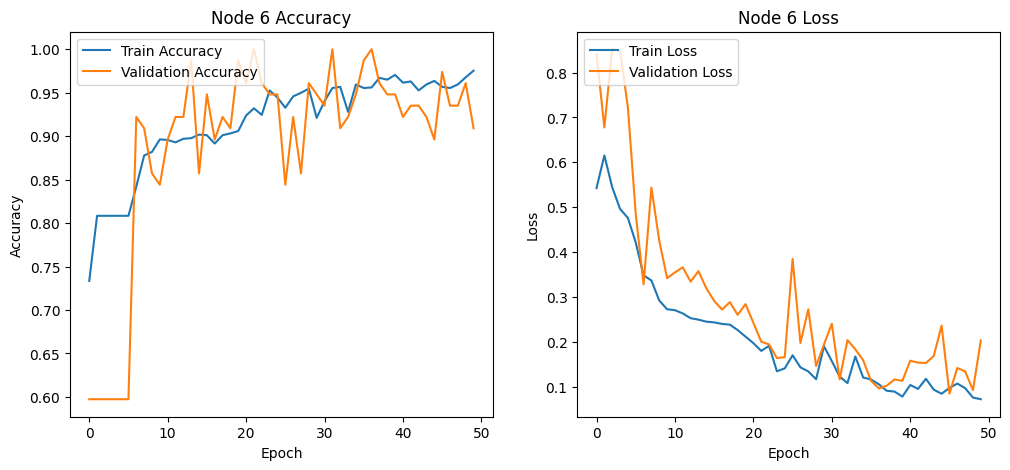

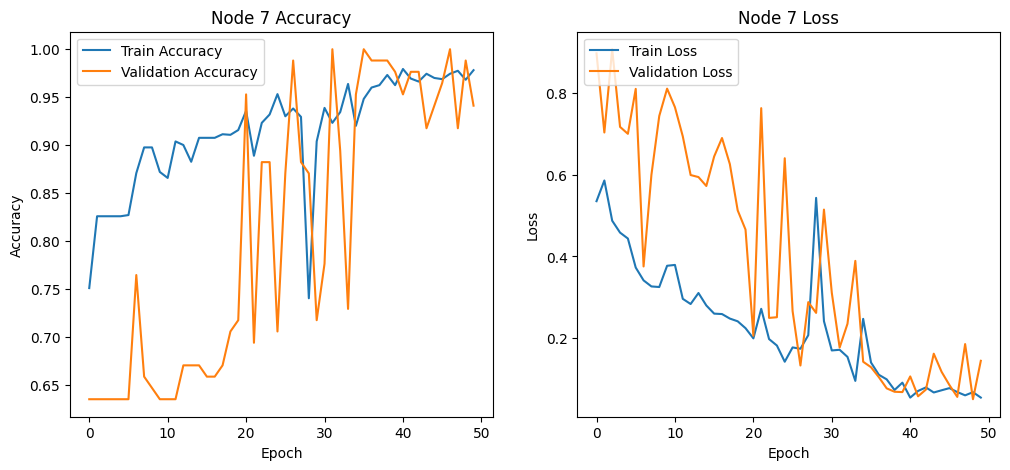

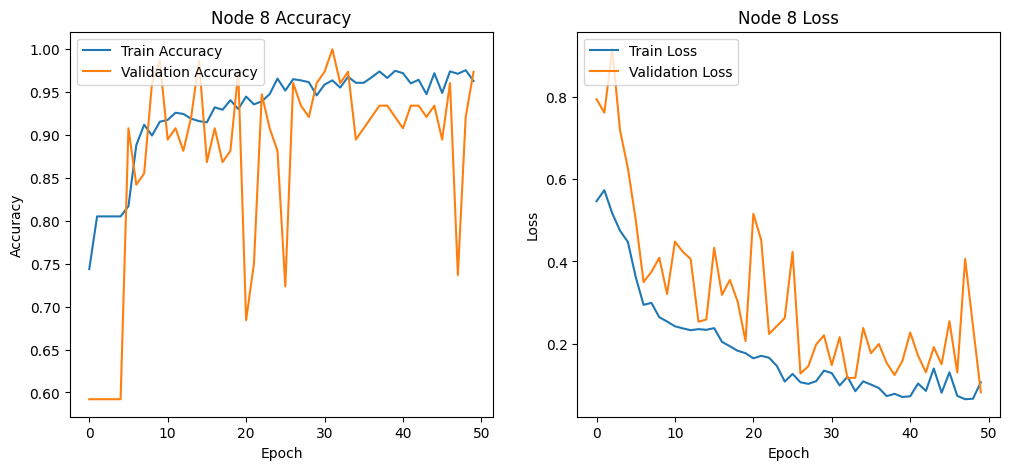

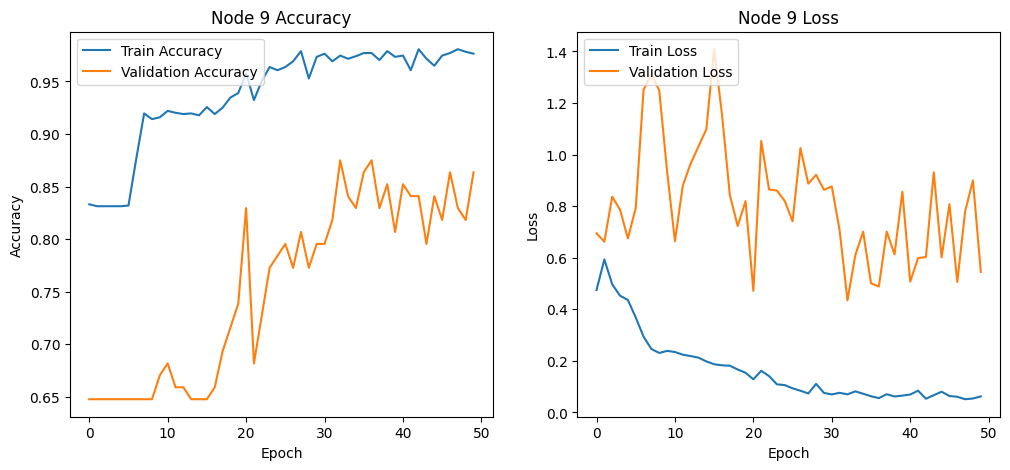

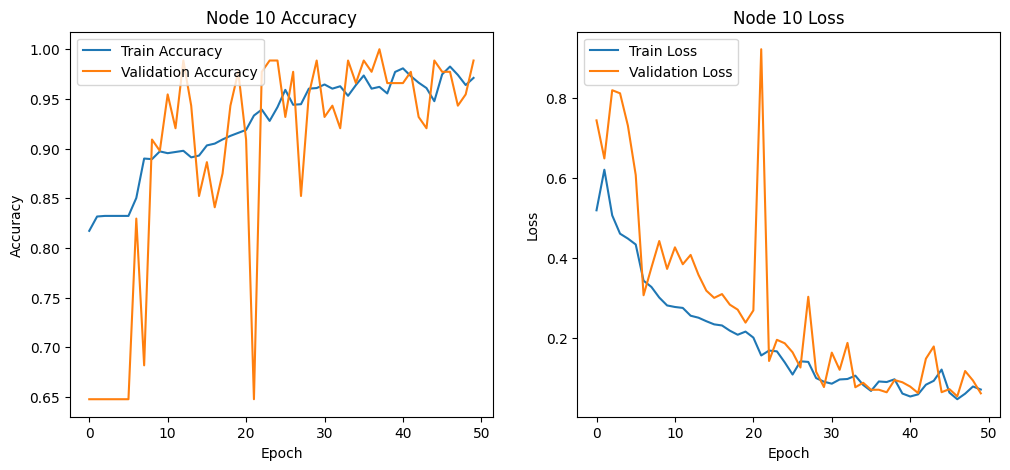

In [9]:
for node_id in sorted(node_histories.keys()):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(node_histories[node_id]['accuracy'], label='Train Accuracy')
    ax1.plot(node_histories[node_id]['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'Node {node_id} Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='upper left')
    
    ax2.plot(node_histories[node_id]['loss'], label='Train Loss')
    ax2.plot(node_histories[node_id]['val_loss'], label='Validation Loss')
    ax2.set_title(f'Node {node_id} Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper left')
    
    plt.show()


In [10]:
##############################################
# EVALUATION OF GOSSIP LSTM MODELS ON TRAINING DATA
##############################################

from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Her node için eğitim verileri (sequence ve label setleri) üzerinde değerlendirme yapalım.
for node_id, model in gossip_models.items():
    print(f"\n--- Evaluating Node {node_id} model on its training data ---")
    
    # Node'ya ait eğitim verilerini alıyoruz:
    X_train = node_sequences_25[node_id]
    y_train = node_labels[node_id]
    
    # Modelin eğitim verisi üzerindeki performansını değerlendiriyoruz:
    scores = model.evaluate(X_train, y_train, verbose=1, batch_size=50)
    print(f"Node {node_id} Train Accuracy: {scores[1]:.4f}")
    
    # Tahminleri alıyoruz:
    y_pred = (model.predict(X_train, verbose=1, batch_size=200) > 0.5).astype("int32")
    
    # Tahminleri CSV'ye kaydediyoruz:
    pd.DataFrame(y_pred, columns=["Prediction"]).to_csv(f'binary_submit_train_node_{node_id}.csv', index=False)
    
    # Confusion matrix hesaplama:
    cm = confusion_matrix(y_train, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Precision ve Recall hesaplama:
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    print(f"Node {node_id} Train Precision: {precision:.4f}")
    print(f"Node {node_id} Train Recall: {recall:.4f}")



--- Evaluating Node 1 model on its training data ---
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9830 - loss: 0.0476
Node 1 Train Accuracy: 0.9798
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Confusion Matrix:
[[1324    2]
 [  31  279]]
Node 1 Train Precision: 0.9929
Node 1 Train Recall: 0.9000

--- Evaluating Node 2 model on its training data ---
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9776 - loss: 0.0585
Node 2 Train Accuracy: 0.9726
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Confusion Matrix:
[[1211   11]
 [  31  279]]
Node 2 Train Precision: 0.9621
Node 2 Train Recall: 0.9000

--- Evaluating Node 3 model on its training data ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9776 - loss: 0.0622
Node 3 Train Accuracy: 0.9666
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Confusion Matrix:
[[1004    5]
 [  39  271]]
Node 3 Train Precision: 0.9819
Node 3 Train Recall: 0.8742

--- Evaluating Node 4 model on its training data ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy

Test set: 93 sequences generated.
Loading model from: /kaggle/working/binary_model_node_1.keras
2/2 - 0s - 199ms/step - accuracy: 0.9140 - loss: 0.1683
Total time taken for inferencing: 0.44 secs
Test Accuracy: 0.9140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step

Confusion Matrix
- x-axis: true labels
- y-axis: predicted labels
[[68  0]
 [ 8 17]]

Test Precision: 1.0000
Test Recall: 0.6800
Test F1-score: 0.8095


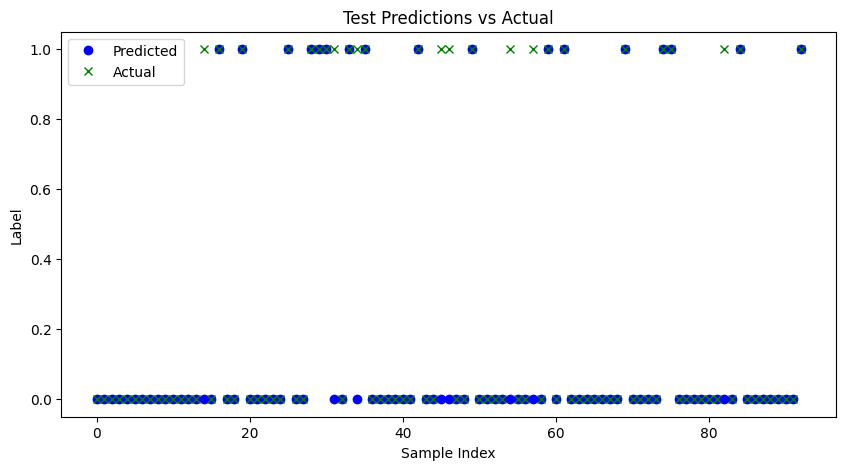

In [11]:
##############################################
# Model Evaluation on Test Set
##############################################

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from tensorflow.keras.models import load_model
import time

# Öncelikle model_path değişkenini tanımlayalım:
model_path = '/kaggle/working/binary_model_node_1.keras'

# 1. Generate Test Sequences:
last_test_seq = [
    test_df[test_df['id'] == engine_id][sequence_cols_25].values[-sequence_length:]
    for engine_id in test_df['id'].unique() if len(test_df[test_df['id'] == engine_id]) >= sequence_length
]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)
print(f"Test set: {last_test_seq.shape[0]} sequences generated.")

# 2. Generate Test Labels:
y_mask = [len(test_df[test_df['id'] == engine_id]) >= sequence_length for engine_id in test_df['id'].unique()]
last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0], 1).astype(np.float32)

# 3. Load the Best Model:
if os.path.isfile(model_path):
    print("Loading model from:", model_path)
    estimator = load_model(model_path)
else:
    print("Model file not found. Using Node 1's model from gossip_models.")
    estimator = gossip_models[1]

# 4. Evaluate Model on Test Set:
start = time.time()
scores_test = estimator.evaluate(last_test_seq, last_test_label, verbose=2, batch_size=50)
end = time.time()
print("Total time taken for inferencing: {:.2f} secs".format(end - start))
print("Test Accuracy: {:.4f}".format(scores_test[1]))

# 5. Predictions and Confusion Matrix:
y_pred_test = (estimator.predict(last_test_seq, verbose=1, batch_size=200) > 0.5).astype("int32")
y_true_test = last_test_label

# Save predictions to CSV:
pd.DataFrame(y_pred_test, columns=["Prediction"]).to_csv('binary_submit_test.csv', index=False)

print("\nConfusion Matrix")
print("- x-axis: true labels")
print("- y-axis: predicted labels")
cm_test = confusion_matrix(y_true_test, y_pred_test)
print(cm_test)

# 6. Compute Precision, Recall, and F1-score:
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test + 1e-8)
print("\nTest Precision: {:.4f}".format(precision_test))
print("Test Recall: {:.4f}".format(recall_test))
print("Test F1-score: {:.4f}".format(f1_test))

# 7. Plot Predictions vs Actual:
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue", marker='o', linestyle='', label="Predicted")
plt.plot(y_true_test, color="green", marker='x', linestyle='', label="Actual")
plt.title("Test Predictions vs Actual")
plt.ylabel("Label")
plt.xlabel("Sample Index")
plt.legend(loc="upper left")
plt.show()


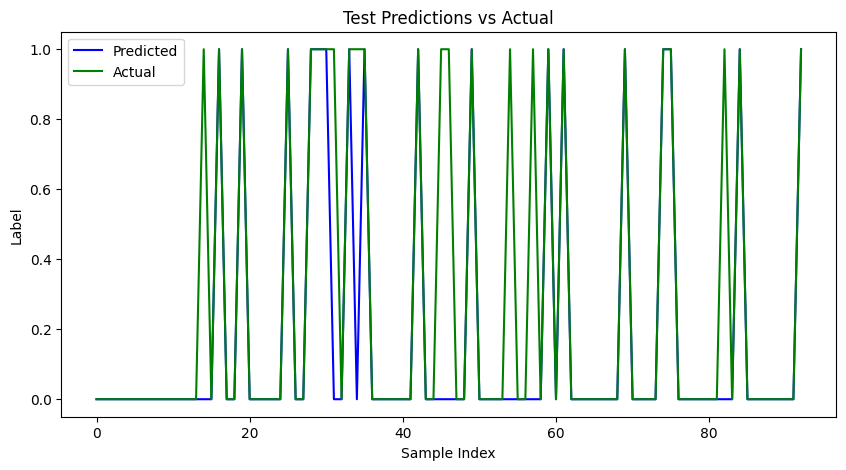

In [12]:
# 7. Plot Predictions vs Actual with Lines
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue", linestyle='-', label="Predicted")
plt.plot(y_true_test, color="green", linestyle='-', label="Actual")
plt.title("Test Predictions vs Actual")
plt.ylabel("Label")
plt.xlabel("Sample Index")
plt.legend(loc="upper left")
plt.show()
